In [400]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import glob

from tensorflow import keras
from keras import layers
from keras.models import Sequential

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

data_dir = pathlib.Path("faces")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6742


In [401]:
img_height = 150
img_width = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

Found 6742 files belonging to 2 classes.
Using 5394 files for training.


In [402]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))

Found 6742 files belonging to 2 classes.
Using 1348 files for validation.


In [403]:
class_names = train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


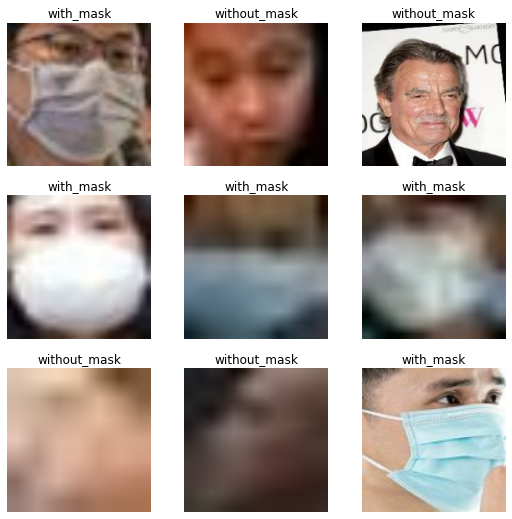

In [404]:
plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(9):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [405]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

<TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


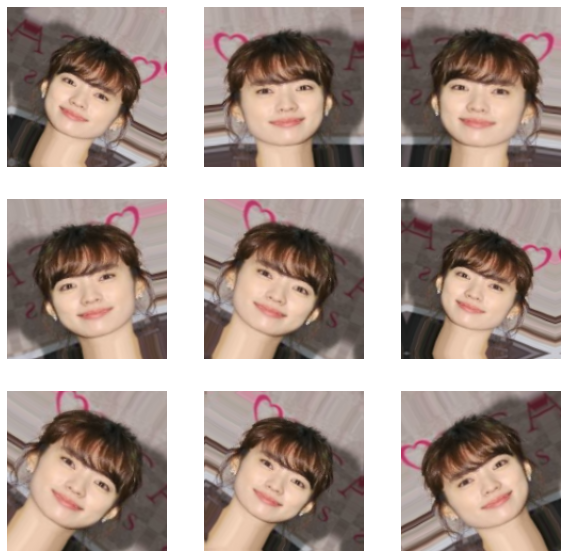

In [406]:
plt.figure(figsize=(10, 10))
print(train_ds.take(1))
for images, _ in train_ds.take(1):

  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off")

In [407]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./ 255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [408]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# model.summary()


In [409]:

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 5,
                                        restore_best_weights = True)

epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
# callbacks=[earlystopping]
)

Epoch 1/10
169/169 [==============================] - 8s 43ms/step - loss: 0.1705 - accuracy: 0.9357 - val_loss: 0.1097 - val_accuracy: 0.9651
Epoch 2/10
169/169 [==============================] - 7s 40ms/step - loss: 0.1087 - accuracy: 0.9605 - val_loss: 0.1029 - val_accuracy: 0.9629
Epoch 3/10
169/169 [==============================] - 7s 40ms/step - loss: 0.1001 - accuracy: 0.9607 - val_loss: 0.0985 - val_accuracy: 0.9622
Epoch 4/10
169/169 [==============================] - 7s 40ms/step - loss: 0.0987 - accuracy: 0.9646 - val_loss: 0.0988 - val_accuracy: 0.9636
Epoch 5/10
169/169 [==============================] - 7s 40ms/step - loss: 0.0959 - accuracy: 0.9640 - val_loss: 0.1009 - val_accuracy: 0.9651
Epoch 6/10
169/169 [==============================] - 7s 40ms/step - loss: 0.0910 - accuracy: 0.9653 - val_loss: 0.1007 - val_accuracy: 0.9681
Epoch 7/10
169/169 [==============================] - 7s 40ms/step - loss: 0.0868 - accuracy: 0.9685 - val_loss: 0.0867 - val_accuracy: 0.9711

[0.9356692433357239, 0.9605116844177246, 0.9606970548629761, 0.964590311050415, 0.9640341401100159, 0.9653318524360657, 0.9684835076332092, 0.9692250490188599, 0.9716351628303528, 0.9692250490188599]
[0.965133547782898, 0.9629080295562744, 0.9621661901473999, 0.9636498689651489, 0.965133547782898, 0.968100905418396, 0.971068263053894, 0.968100905418396, 0.9755192995071411, 0.9732937812805176]


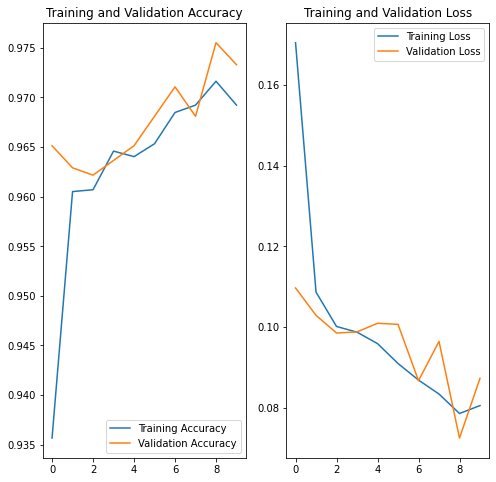

In [410]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

print(acc)
print(val_acc)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [411]:
testing_images = glob.glob('./testing/*.*')

for test_image in testing_images:
    image_path = pathlib.Path(test_image)

    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(test_image)
    print(class_names)
    print(score)
    print(np.argmax(score))
    print(
        "{} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print('---------------------------------------')

./testing\1.png
['with_mask', 'without_mask']
tf.Tensor([0.9982212  0.00177871], shape=(2,), dtype=float32)
0
with_mask with a 99.82 percent confidence.
---------------------------------------
./testing\2.png
['with_mask', 'without_mask']
tf.Tensor([0.7697914  0.23020853], shape=(2,), dtype=float32)
0
with_mask with a 76.98 percent confidence.
---------------------------------------
./testing\3.jpg
['with_mask', 'without_mask']
tf.Tensor([0.30581337 0.6941866 ], shape=(2,), dtype=float32)
1
without_mask with a 69.42 percent confidence.
---------------------------------------
./testing\4.png
['with_mask', 'without_mask']
tf.Tensor([0.9856753  0.01432469], shape=(2,), dtype=float32)
0
with_mask with a 98.57 percent confidence.
---------------------------------------
./testing\5.jpg
['with_mask', 'without_mask']
tf.Tensor([9.9938881e-01 6.1121973e-04], shape=(2,), dtype=float32)
0
with_mask with a 99.94 percent confidence.
---------------------------------------
./testing\6.png
['with_mas